In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
EXPANSION_FACTOR = 32

In [4]:
# OVERRIDE = True
OVERRIDE = False

path = f"../data/pickled_linearizers/gelu_1l_{EXPANSION_FACTOR}.pkl"

# Automated SAE name generation
seeds = [42, 43]
# layers = [0, 1]
names1 = ["ln2_normalized", "mlp_out", "transcoder"]
names2 = ["ln2.hook_normalized", "hook_mlp_out", "ln2.hook_normalized"]

sae_names = []
for seed in seeds:
    # for layer in layers:
    for name1, name2 in zip(names1, names2):
        sae_names.append(
            f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_1l/seed{seed}_{name1}/final_sparse_autoencoder_gelu-1l_blocks.0.{name2}_{512 * EXPANSION_FACTOR}.pt"
        )

if os.path.exists(path) and not OVERRIDE:
    lin = pickle.load(open(path, "rb"))
else:
    lin = SAELinearizer(
        model_name="gelu-1l",
        sae_names=sae_names,
        layers=[0, 0, 0, 0, 0, 0],
        dataset_name="NeelNanda/pile-10k",
        act_name="normalized",
        num_batches=10,
        half_precision=False,
        # transcoder=True,
        # use_gpt=True,
        # dict_mult=64,
        # hook_point="resid_mid",
        run_analysis=True,
    )
    with open(path, "wb") as f:
        pickle.dump(lin, f)

In [5]:
# 5 features, uniformly sampled by frequency, seed 42 layer 0:

# sae_name = "../scripts/checkpoints/32x_gelu_2l/layer0/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt"
LAYER = 0
SEED = 42
sae_name = f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.{LAYER}.ln2.hook_normalized_{512 * EXPANSION_FACTOR}.pt"
freqs = lin.frequencies[sae_name]

my_sample = np.argsort(freqs.cpu().numpy())[::-1][:: len(freqs) // 5]
print(" ".join([f"{x}: {freqs[x].item()}" for x in my_sample]))

11712: 0.2850708067417145 5150: 0.02271728590130806 4482: 0.004931640811264515 14892: 0.0018066406482830644 855: 0.0007812500116415322 13771: 0.0


In [8]:
def set_and_visualize(feature_idx):
    lin.set_feature(feature_idx, sae_name, num_batches=10)

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))

    ax = visualize_topk(
        examples=lin.top_examples["examples"].detach().cpu().numpy(),
        activations=lin.top_examples["activations"].detach().cpu().numpy(),
        columns=lin.top_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[0],
    )
    axs[0].set_title(f"Feature {lin.feature_idx} for Transcoder, top")

    ax = visualize_topk(
        examples=lin.uniform_ranked_examples["examples"].detach().cpu().numpy(),
        activations=lin.uniform_ranked_examples["activations"].detach().cpu().numpy(),
        columns=lin.uniform_ranked_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[1],
    )
    axs[1].set_title(f"Feature {lin.feature_idx} for Transcoder, uniform")

    fig.suptitle(f"Feature {feature_idx}, sparsity: {100*lin.frequencies[sae_name][feature_idx]:.3f}%")

    plt.tight_layout()
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 22.17it/s]


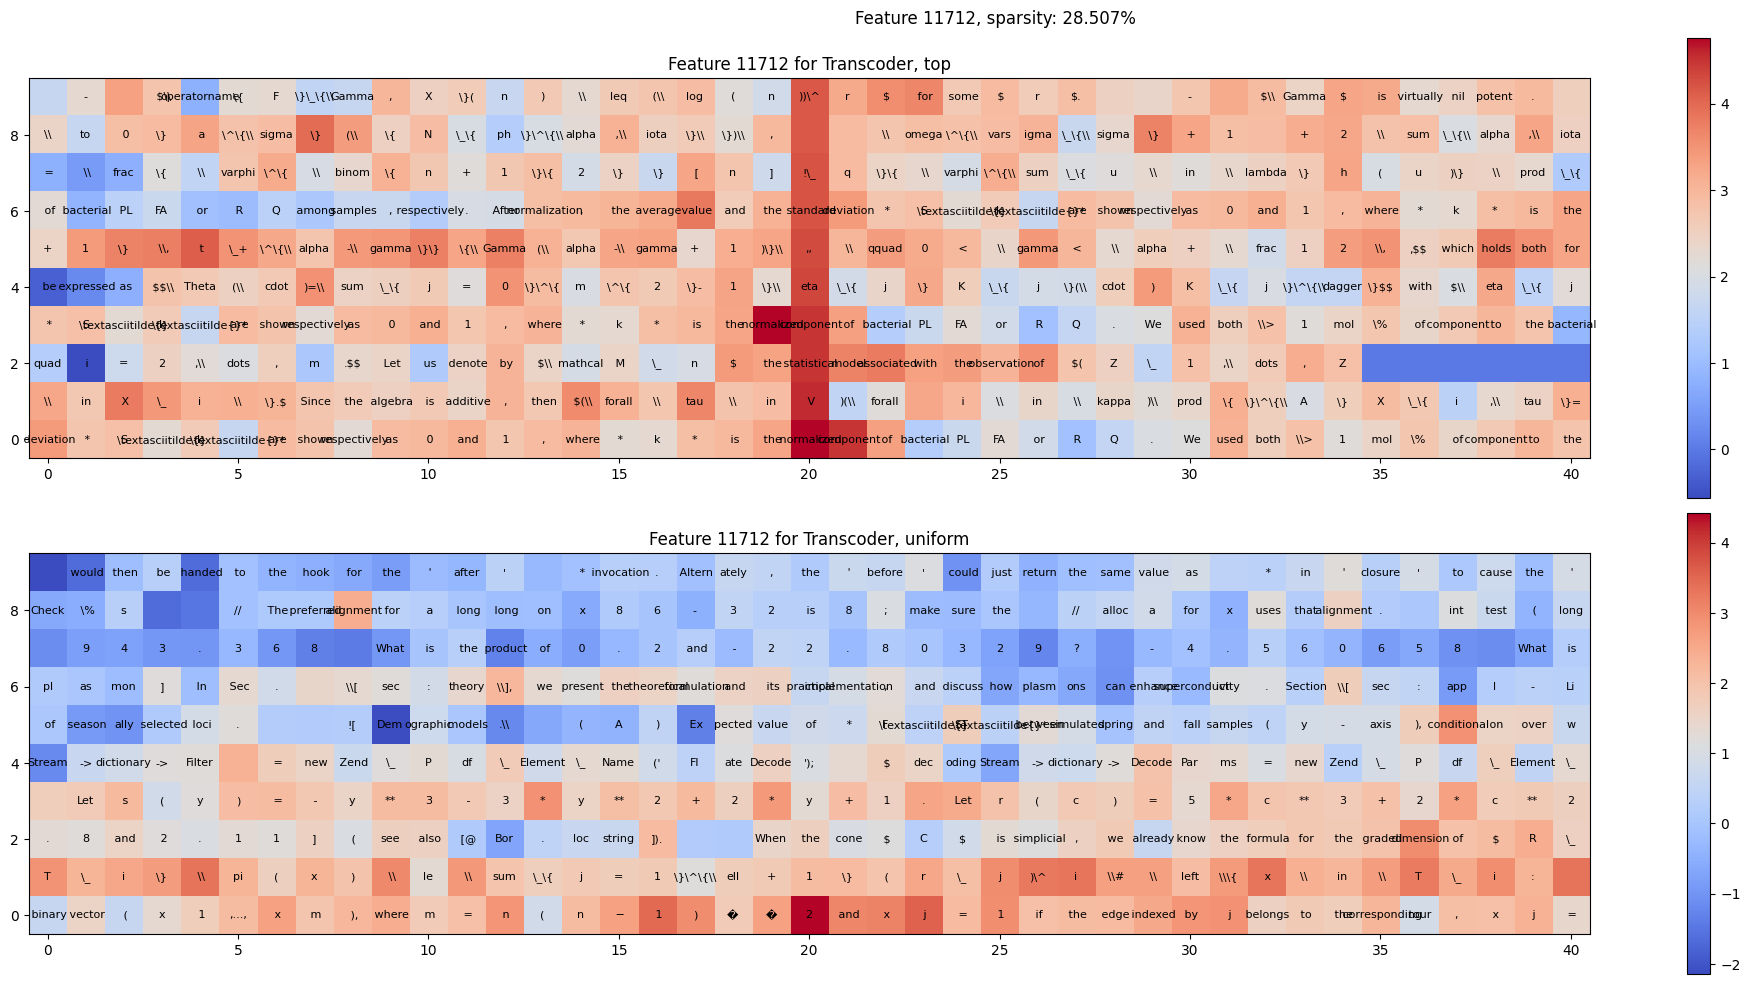

In [9]:
set_and_visualize(my_sample[0])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 26.25it/s]
) missing from current font.4980.py:30: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.ats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


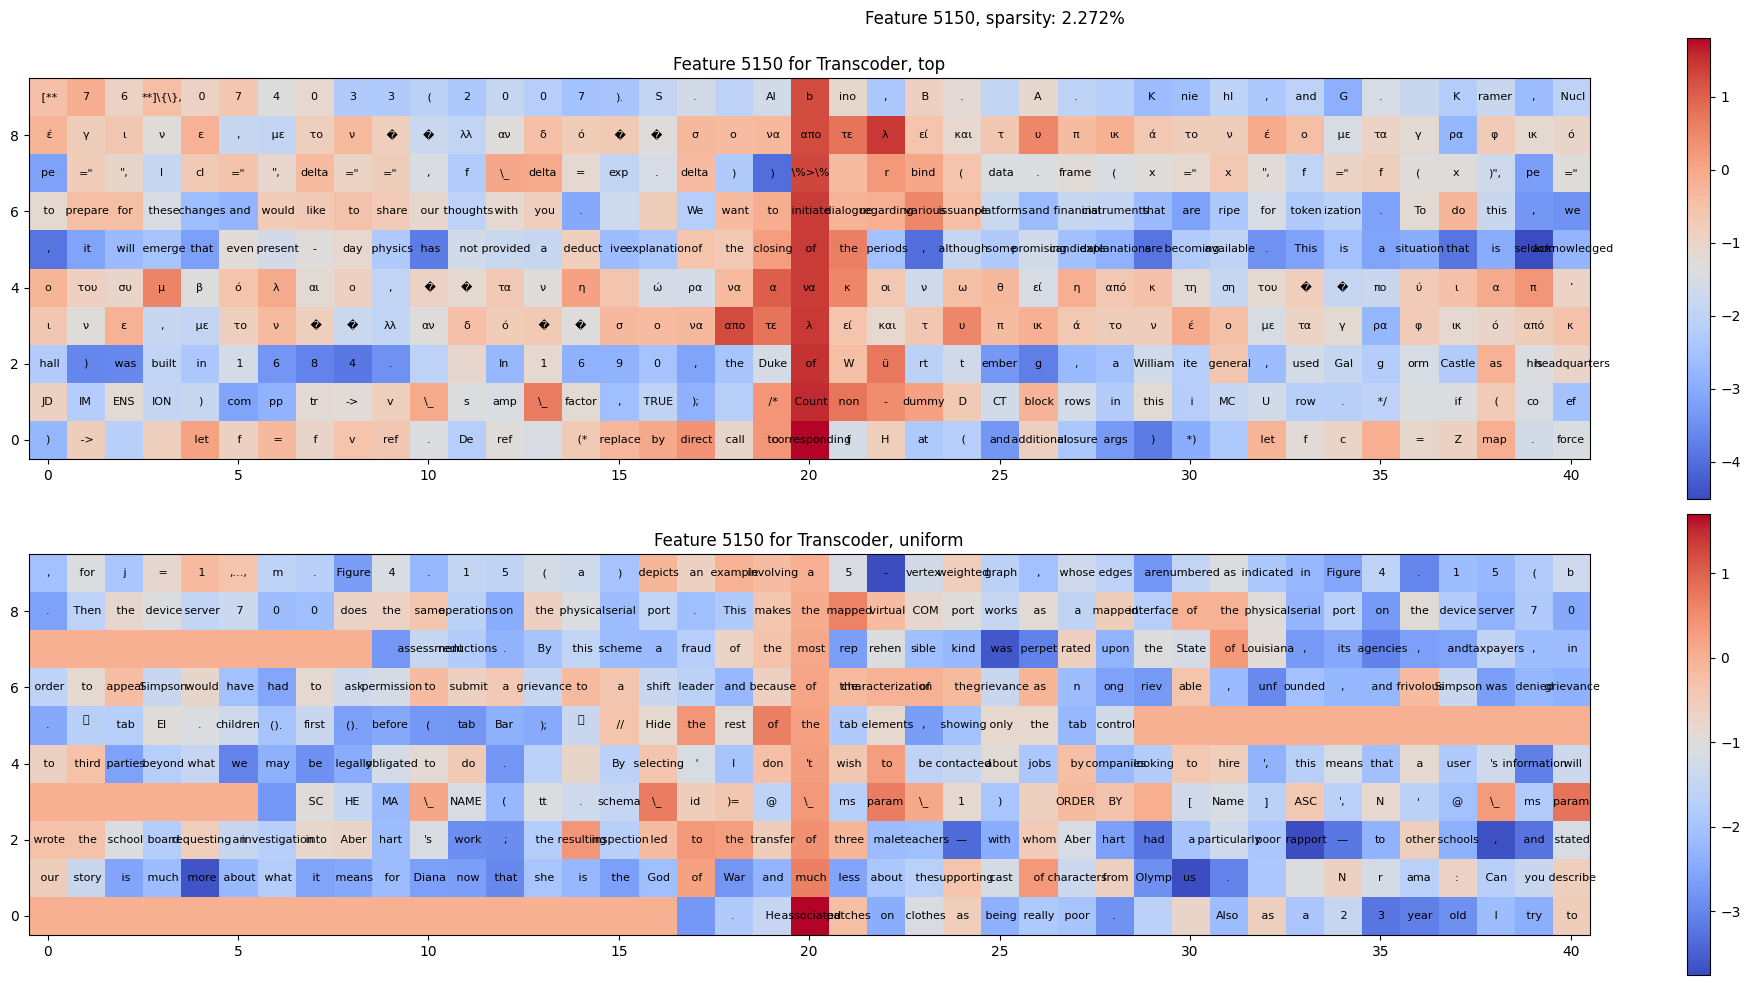

In [10]:
set_and_visualize(my_sample[1])

100%|██████████| 10/10 [00:00<00:00, 21.93it/s]


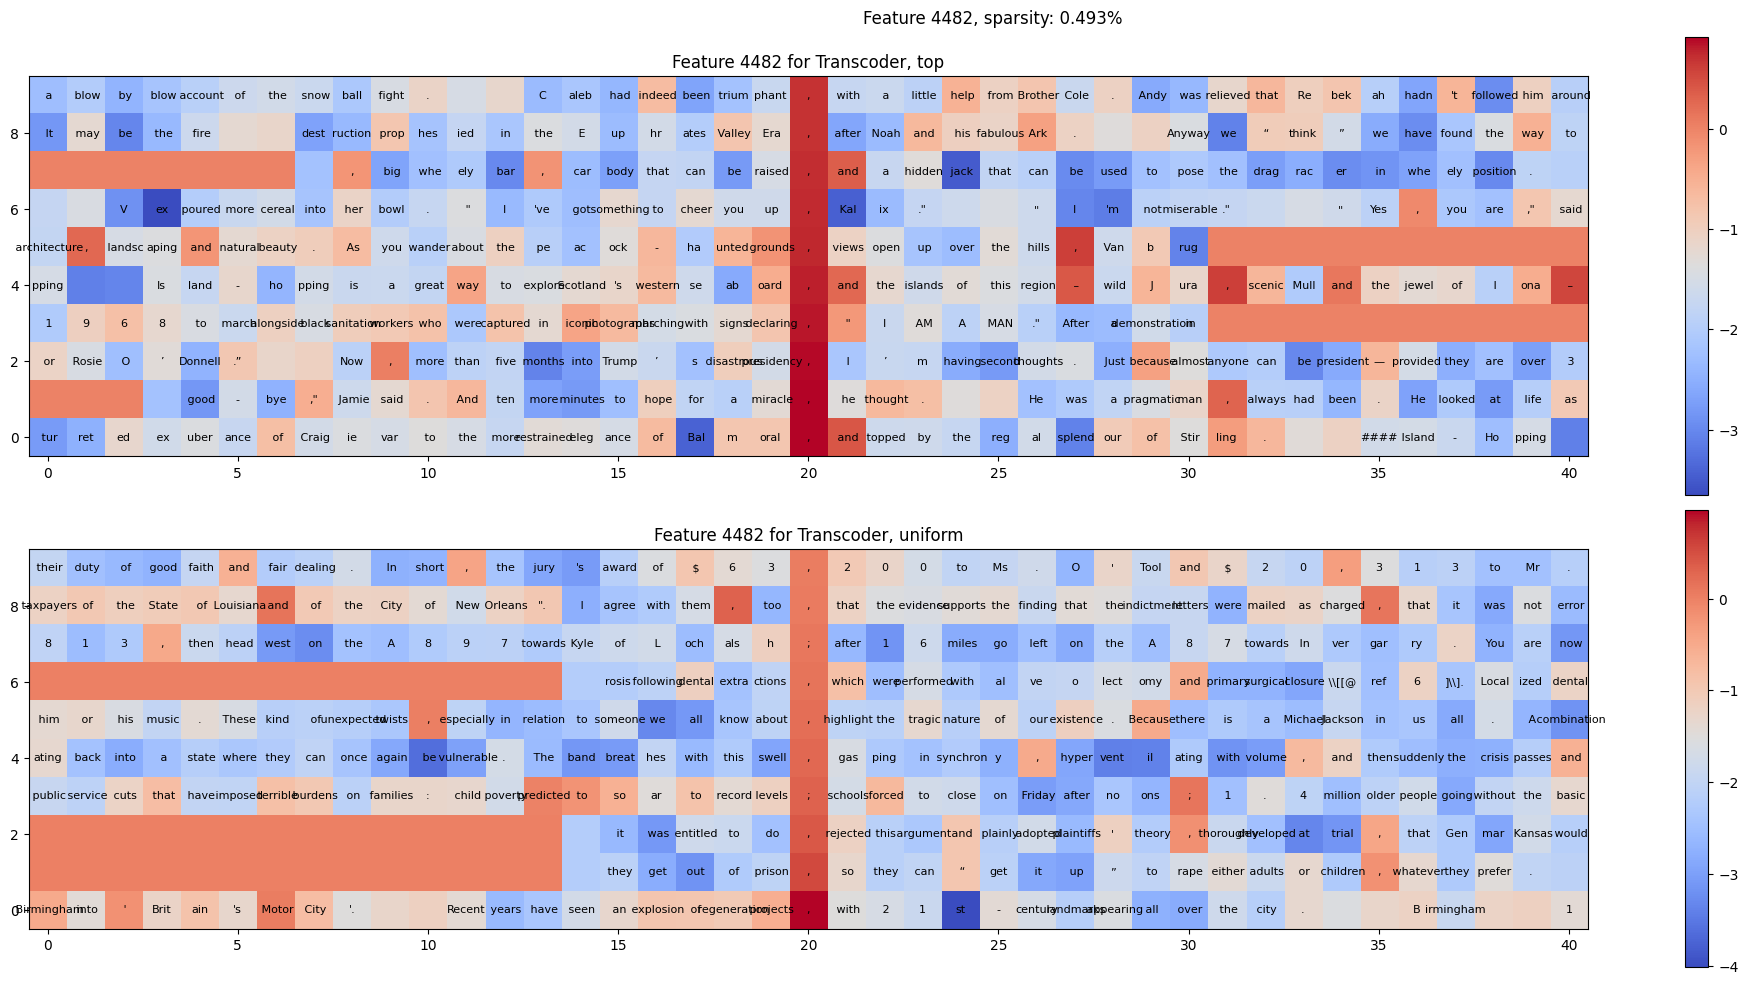

In [11]:
set_and_visualize(my_sample[2])

100%|██████████| 10/10 [00:00<00:00, 26.46it/s]


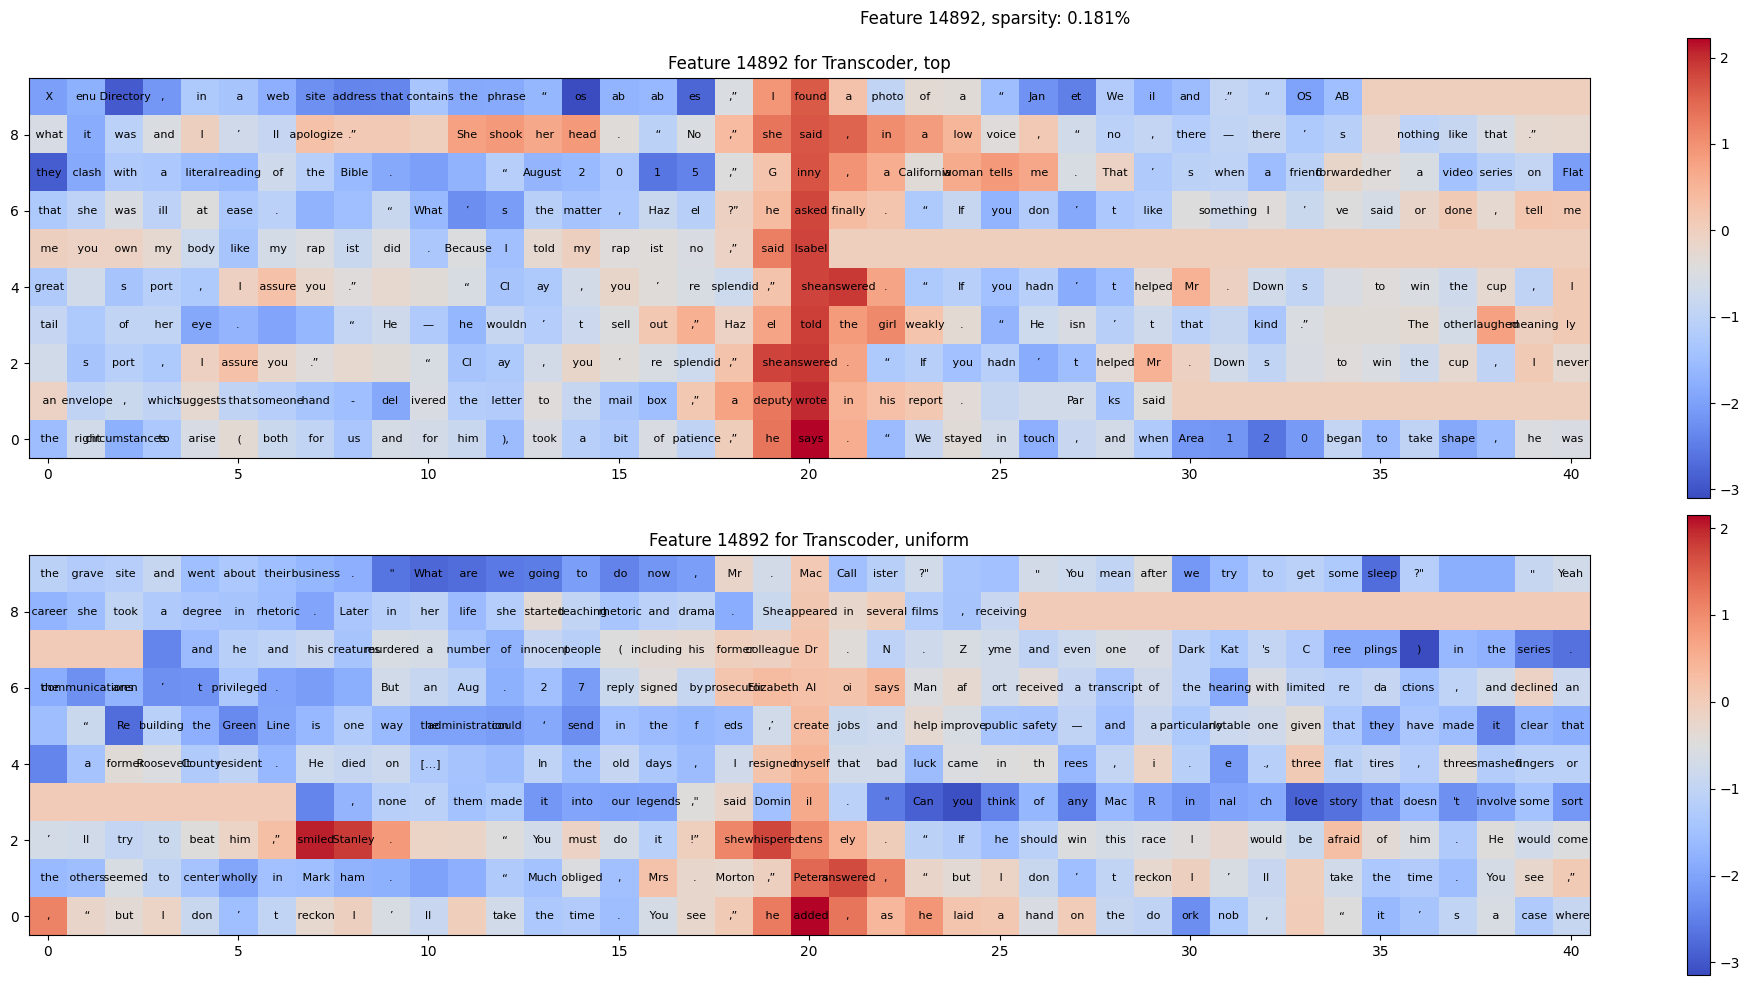

In [12]:
set_and_visualize(my_sample[3])

100%|██████████| 10/10 [00:00<00:00, 32.24it/s]


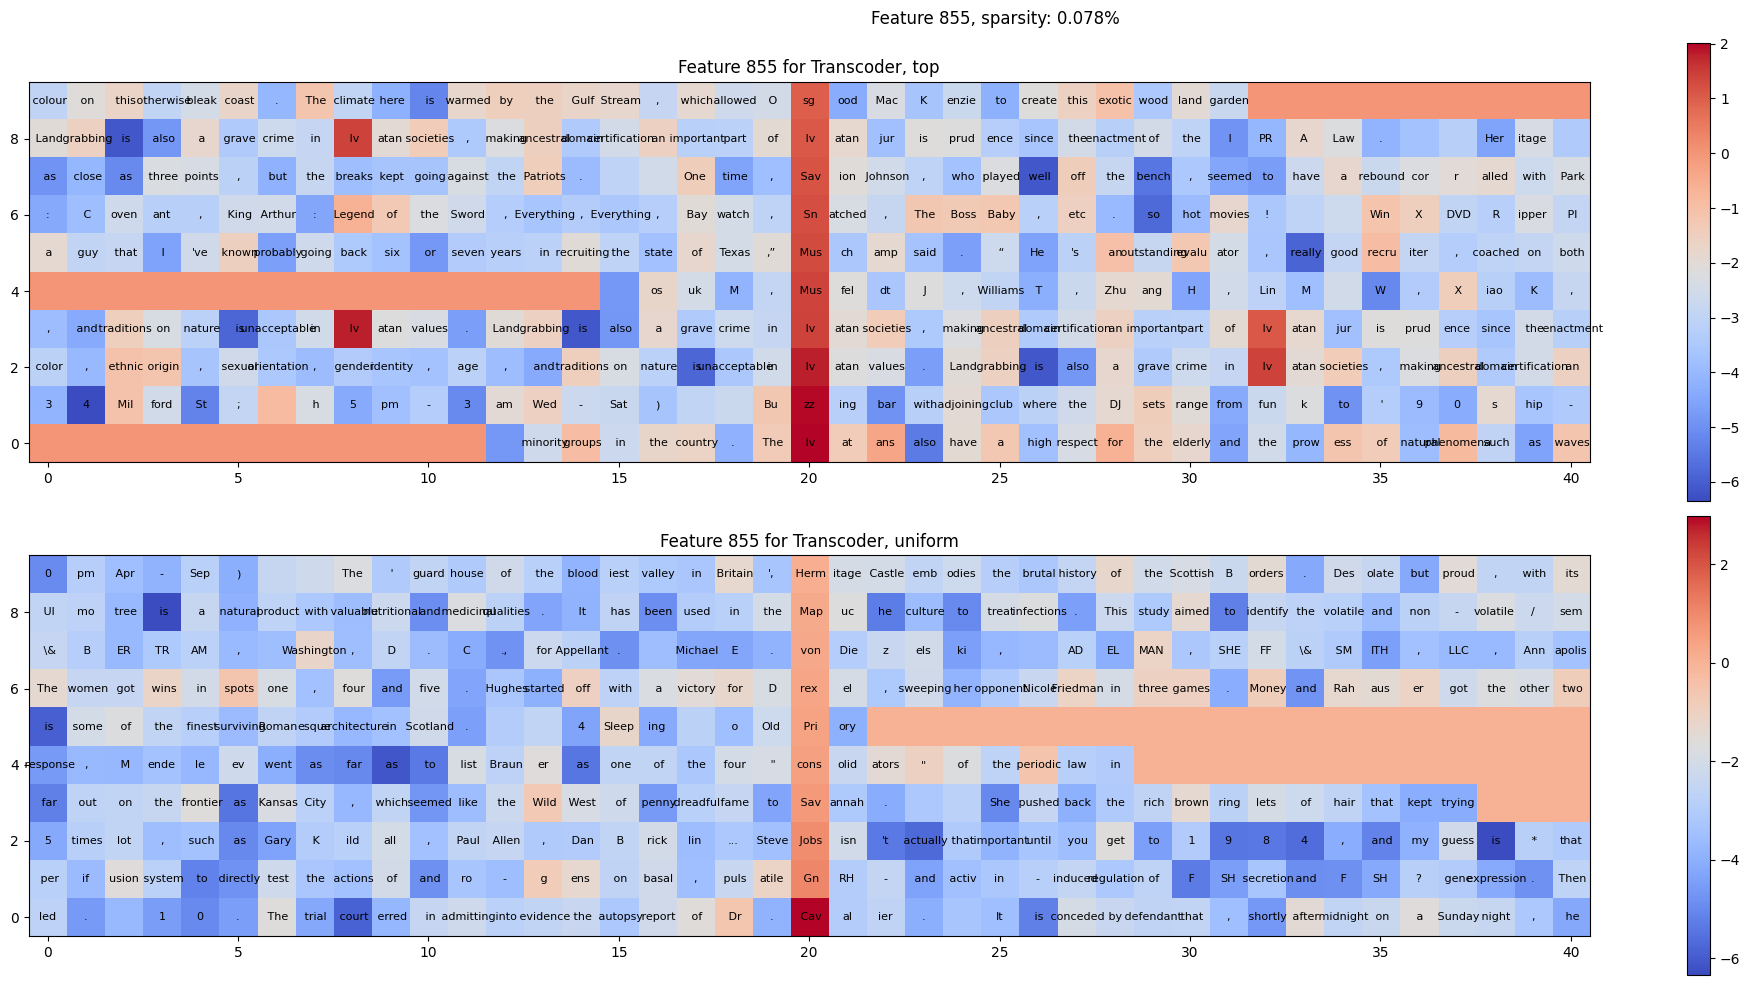

In [13]:
set_and_visualize(my_sample[4])